## Installations and Dependencies

In [ ]:
# Installations
!pip install transformers
!pip install torchmetrics
!pip install torchxrayvision
!pip install pytorch-lightning
!pip install scikit-plot
!pip install idx2numpy
!pip install python-mnist

In [ ]:
# File Management
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import idx2numpy
from PIL import Image
from mnist import MNIST

# Utilities
from __future__ import print_function
import argparse, random, copy
import numpy as np
import tqdm

# Torch imports
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import torchvision
from torchvision import datasets
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR

# Dataset
import torchxrayvision as xrv
from mnist import MNIST

# SKLearn
import sklearn
import scikitplot as skplt
from sklearn.model_selection import train_test_split

# Premade Transformers
from transformers import AutoModel

## Preprocessing

In [ ]:
# Configure to Google Drive
drive.mount('/content/gdrive')

%cd "gdrive"
%cd "MyDrive"
%cd "RESEARCH - Radiological Report Generation (Troy)"
%cd "similarity"
%cd "data"
%cd "MNIST"
%cd "mnist"

%ls

### Use MNIST Dataset

In [ ]:
# Load MNIST data from directory (downloaded from https://yann.lecun.com/)
mndata = MNIST('.')
images, labels = mndata.load_training()

# Convert from 1D-array to grayscale 224x224 to 2D-array
for img in tqdm.tqdm(range(len(images))):
  old_img = images[img]
  new_img = []
  collective_k = 0

  for i in range(28):
    new_img.append([])
    for j in range(28):
      oi = old_img[collective_k]
      new_img[-1].append(oi)
      collective_k += 1

  new_img = np.asarray(new_img).astype(np.uint8)
  new_img = Image.fromarray(new_img, 'L')
  new_img = new_img.resize((224, 224), Image.BILINEAR)
  images[img] = np.array(new_img)

In [ ]:
# Making sure that the images actually loaded...
ind = random.randint(0, len(images)-1)
pix = images[ind]
label = labels[ind]
print(f"Label: {label}")
plt.imshow(pix, cmap='gray')

In [ ]:
# Filter out ones from non-ones and store them neatly in the array
ones = []
not_ones = []
for ind, item in enumerate(images):
  if labels[ind] == 1:
    ones.append((ind, item))
  else:
    not_ones.append((ind, item))

random.shuffle(ones)
random.shuffle(not_ones)

# Add them to a dataset array
dataset_imgs = []
prevpkl = dict()
currentpkl = dict()
for i in range(1, len(ones)):
  prevpkl[ones[i][0]] = ones[i][1]
  currentpkl[ones[i-1][0]] = ones[i-1][1]
  dataset_imgs.append({"comparison": 0, "before": ones[i][1], "after": ones[i-1][1]})

for i in range(0, len(ones)):
  prevpkl[ones[i][0]] = ones[i][1]
  currentpkl[not_ones[i][0]] = not_ones[i][1]
  dataset_imgs.append({"comparison": 1, "before": ones[i][1], "after": not_ones[i][1]})

# Just name it csv_df and shuffle
csv_df = dataset_imgs
random.shuffle(csv_df)

## Base Architecture

In [ ]:
# Configurations for Siamese Network
config = {
    "d_model": 512,
    "dropout": 0.2,
    "num_classes": 2,
    "lr": 1e-3
}

# Siamese Network Architecture
class SiameseNetwork(nn.Module):
    def __init__(self):
        """
        The siamese network architecture makes use of two parallel neural
        networks that learn to, in this case, be able to successfully
        encode and distinguish between two images.
        """
        super(SiameseNetwork, self).__init__()

        # 101-elastic is trained on PadChest, NIH, CheXpert, and MIMIC datasets
        self.cnn1 = xrv.autoencoders.ResNetAE(weights="101-elastic")
        self.nclasses = config["num_classes"]

        outdim = 512 * 3 * 3 * 2

        for param in self.cnn1.parameters():
            param.requires_grad = False

        self.fc = nn.Linear(outdim, config["d_model"])
        self.dropout = nn.Dropout(config["dropout"], inplace=False)
        self.fc_final = nn.Linear(config["d_model"], config["num_classes"])
        self.learning_rate = config["lr"]

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output["z"].view(-1, 512*3*3)
        return output

    def forward(self, input1, input2):
        # Parallel networks in action
        prev_image_features = self.forward_once(input1)
        curr_image_features = self.forward_once(input2)

        # Combine the features, and generate the output
        image_features = torch.cat((prev_image_features, curr_image_features), 1)
        image_features = F.relu(self.fc(image_features))
        image_features = self.dropout(image_features)
        classifier_output = self.fc_final(image_features)

        return classifier_output

class SiameseDataset(Dataset):
    def __init__(self, data, prev_pkl, current_pkl):
        super(SiameseDataset, self).__init__()
        """
        The SiameseDataset object stores the data into something neat and accessible.
        """
        self.data = data
        self.prev_pkl = prev_pkl
        self.current_pkl = current_pkl
        self.greyscale = torchvision.transforms.Grayscale(1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_1 = self.data[index]["before"]
        image_1 = image_1[None, :]
        image_2 = self.data[index]["after"]
        image_2 = image_2[None, :]

        return {"prev_img": image_1, "curr_img": image_2, "change": self.data[index]["comparison"]}

### Just to test if nothing broke (code-wise)...

In [ ]:
# Load the dataset and dataloaders

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_df, test_df = train_test_split(csv_df, shuffle=True)
train_ds = SiameseDataset(train_df, prevpkl, currentpkl)
test_ds = SiameseDataset(test_df, prevpkl, currentpkl)
train_data_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
test_data_loader = DataLoader(test_ds, batch_size=4, shuffle=True)

# Try out one batch and see what the model spits out

batch = next(iter(train_data_loader))
batch['prev_img'] = batch['prev_img'].float().to(device)
batch['curr_img'] = batch['curr_img'].float().to(device)
batch['change'] = batch['change'].to(device)

model = SiameseNetwork().to(device)
model(batch["prev_img"], batch["curr_img"])

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nihpcrsnamimic_ch-resnet101-2-ae-test2-elastic-e250.pt -O /root/.torchxrayvision/models_data/nihpcrsnamimic_ch-resnet101-2-ae-test2-elastic-e250.pt`
[██████████████████████████████████████████████████]


tensor([[ 0.1033,  0.0691],
        [ 0.8053,  0.2789],
        [ 0.4051, -0.2872],
        [-0.7182,  0.0312]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Training and Testing

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    """
    This uses CrossEntropyLoss. Although BinaryEntropyLoss function could
    also be used, the documentation preferred using CrossEntropyLoss.

    Other than that, this is essentially training the model.
    """
    model.train()
    criterion = nn.CrossEntropyLoss()

    for batch_idx, batch in enumerate(tqdm.tqdm(train_loader)):
        targets = batch["change"].type(torch.LongTensor)

        images_1 = batch["prev_img"].float().to(device)
        images_2 = batch["curr_img"].float().to(device)
        targets = batch["change"].to(device)

        optimizer.zero_grad()
        outputs = model(images_1, images_2)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images_1), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    """
    This function tells the accuracy and loss of the model.
    """
    model.eval()
    test_loss = 0
    correct = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in test_loader:
            targets = batch["change"].type(torch.LongTensor)
            images_1 = batch["prev_img"].float().to(device)
            images_2 = batch["curr_img"].float().to(device)
            targets = batch["change"].to(device)

            outputs = model(images_1, images_2)
            test_loss += criterion(outputs, targets).sum().item()
            pred = outputs.argmax(1)
            correct += pred.eq(targets).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

"""
------------- RUN THE TRAIN-TEST LOOP -------------
"""

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_df, test_df = train_test_split(csv_df, shuffle=True)
train_ds = SiameseDataset(train_df, prevpkl, currentpkl)
test_ds = SiameseDataset(test_df, prevpkl, currentpkl)
train_data_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
test_data_loader = DataLoader(test_ds, batch_size=4, shuffle=True)

model = SiameseNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=config["lr"])

epochs = 100
for epoch in range(1, epochs + 1):
    train(model, device, train_data_loader, optimizer, epoch)
    test(model, device, test_data_loader)

## Prediction Generation

In [ ]:
def predict(prev_img, curr_img, convert=True):
    """
    Translates to make model prediction readable
    """
    prv_img = prev_img.unsqueeze(0).to(device)
    crr_img = curr_img.unsqueeze(0).to(device)
    m = torch.nn.Sigmoid()
    pred = m(model(prv_img, crr_img))

    if convert:
      pred = pred.argmax(1)
      if pred == 0:
        return "no change"
      else:
        return "changed"

    return pred

In [ ]:
"""
Note: 101-elastic weights only accept grayscale images
"""
grayscale = torchvision.transforms.Grayscale(1)

Reference: 0 (not changed)
Generated: no change


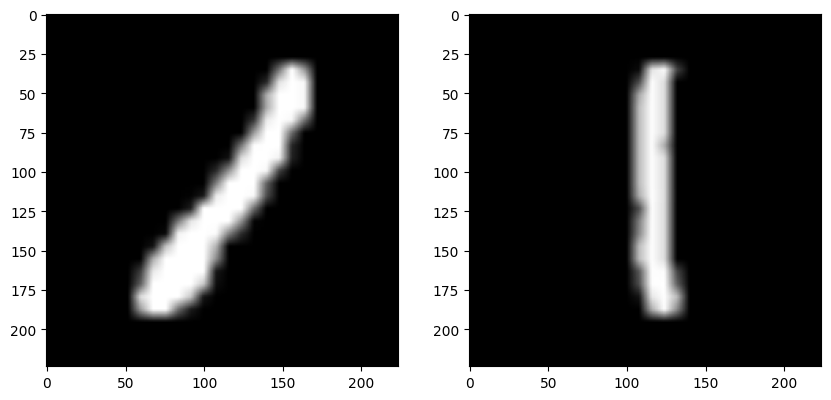

In [ ]:
"""
This block of code gives out sample two images, and tests out how the model reacts
"""

row = test_df[random.randint(0, len(test_df)-1)]
prev_img = row["before"]
prev_img = prev_img[None, :]
prev_img = torch.from_numpy(prev_img)

curr_img = row["after"]
curr_img = curr_img[None, :]
curr_img = torch.from_numpy(curr_img)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(torch.permute(prev_img, (1, 2, 0)), cmap='gray')
ax[1].imshow(torch.permute(curr_img, (1, 2, 0)), cmap='gray')

progression_dict = {1: "changed", 0: "not changed"}

pe = row['comparison']
print(f"Reference: {pe} ({progression_dict[pe]})")
print(f"Generated: {predict(prev_img.float(), curr_img.float())}")